In [37]:
import matplotlib.pyplot as plt
from utils.util_metrics import *
from utils.util_draw import *
import warnings
from IPython.display import Image, display
warnings.filterwarnings('ignore')
import utils.ai_plotting as aiplt
import matplotlib.pyplot as plt
import json
import glob
import natsort as ns
import seaborn as sns
print(plt.style.available)
aiplt.aingura_plot_style(grid_color='white', plt_style='seaborn-v0_8-white')



['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


### SAME STRUCTURE

In [3]:
exp = f'results/exp_simu/Mfix'
head = 15
thres = 0.5
sortby = {"by": 'shamming', "ascending": True}


with open('results/exp_simu/Mfix/simu_all_50.json', 'r') as json_file:
    results50 = json.load(json_file)
with open('results/exp_simu/Mfix/simu_all_80.json', 'r') as json_file:
    results80 = json.load(json_file)
    
with open('results/exp_simu/Mfix2/simu_all_50.json', 'r') as json_file:
    results2_50 = json.load(json_file)
with open('results/exp_simu/Mfix2/simu_all_80.json', 'r') as json_file:
    results2_80 = json.load(json_file)


for (k1,res), (k2,res2) in zip(results80.items(), results2_80.items()):
    print(res.keys(), res2.keys())
    results80[k1].update(res2)

    print(results80[k1].keys(), res2.keys(),'\n')

for k1,res in results80.items():
    print(k1, res.keys())

os.makedirs('results/exp_simu/Mfix3', exist_ok=True)
with open('results/exp_simu/Mfix3/simu_all_80.json', 'w') as json_file:
    json.dump(results80, json_file)

dict_keys(['2048', '4096', '8192']) dict_keys(['16384'])
dict_keys(['2048', '4096', '8192', '16384']) dict_keys(['16384']) 

dict_keys(['2048', '4096', '8192']) dict_keys(['16384'])
dict_keys(['2048', '4096', '8192', '16384']) dict_keys(['16384']) 

dict_keys(['2048', '4096', '8192']) dict_keys(['16384'])
dict_keys(['2048', '4096', '8192', '16384']) dict_keys(['16384']) 

dict_keys(['2048', '4096', '8192']) dict_keys(['16384'])
dict_keys(['2048', '4096', '8192', '16384']) dict_keys(['16384']) 

dict_keys(['2048', '4096', '8192']) dict_keys(['16384'])
dict_keys(['2048', '4096', '8192', '16384']) dict_keys(['16384']) 

dict_keys(['2048', '4096', '8192']) dict_keys(['16384'])
dict_keys(['2048', '4096', '8192', '16384']) dict_keys(['16384']) 

dict_keys(['2048', '4096', '8192']) dict_keys(['16384'])
dict_keys(['2048', '4096', '8192', '16384']) dict_keys(['16384']) 

1.SPBN dict_keys(['2048', '4096', '8192', '16384'])
2.BSBN dict_keys(['2048', '4096', '8192', '16384'])
3.BSBN-Linear dict_ke

#### STRUCTURE

['results/exp_simu/Mfix/simu_all_50.json', 'results/exp_simu/Mfix/simu_all_80.json', 'results/exp_simu/Mfix/simu_all_100.json']
                         hamming  shamming  thamming        train         slogl     slogl_REF  Ratio Train   Logl diff    Ratio Test Instances Simulation
Model                                                                                                                                                    
1.SPBN                  2.000000  3.666667  0.066667    15.693360 -29560.459753 -29401.085507     1.000000  159.374247  6.181983e+09      2048          1
1.SPBN                  2.000000  2.666667  0.266667    47.954393 -57058.342480 -57099.932960     1.000000  -41.590480  4.337932e+09      2048          2
1.SPBN                  0.000000  0.933333  0.000000     9.190293 -35154.232107 -35143.818720     1.000000   10.413387  1.089641e+10      2048          3
1.SPBN                  1.466667  2.733333  0.733333    30.728567 -65655.649600 -65608.719107     1.00

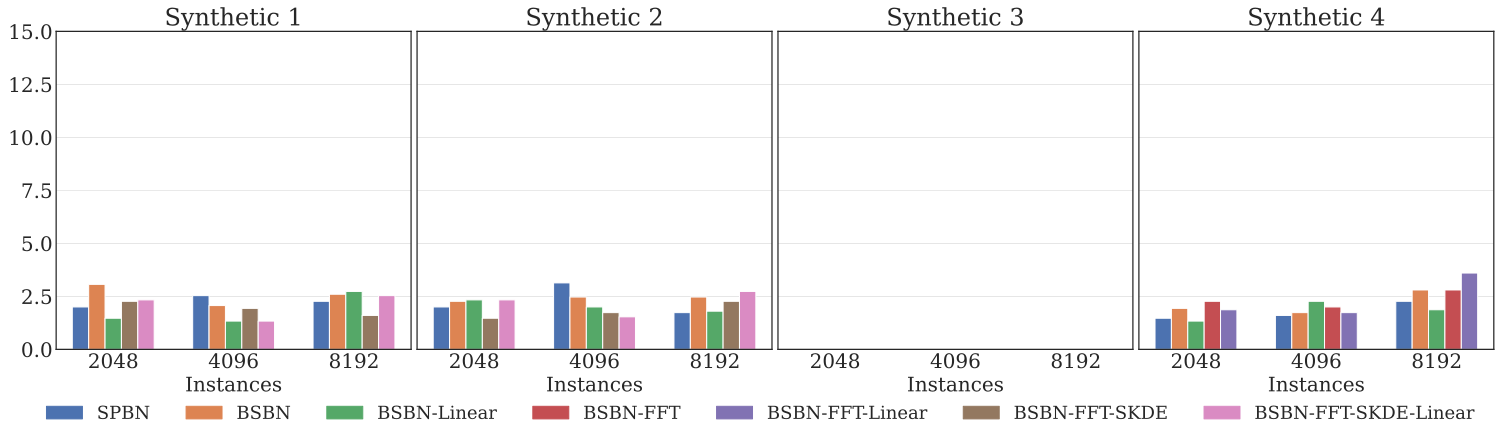

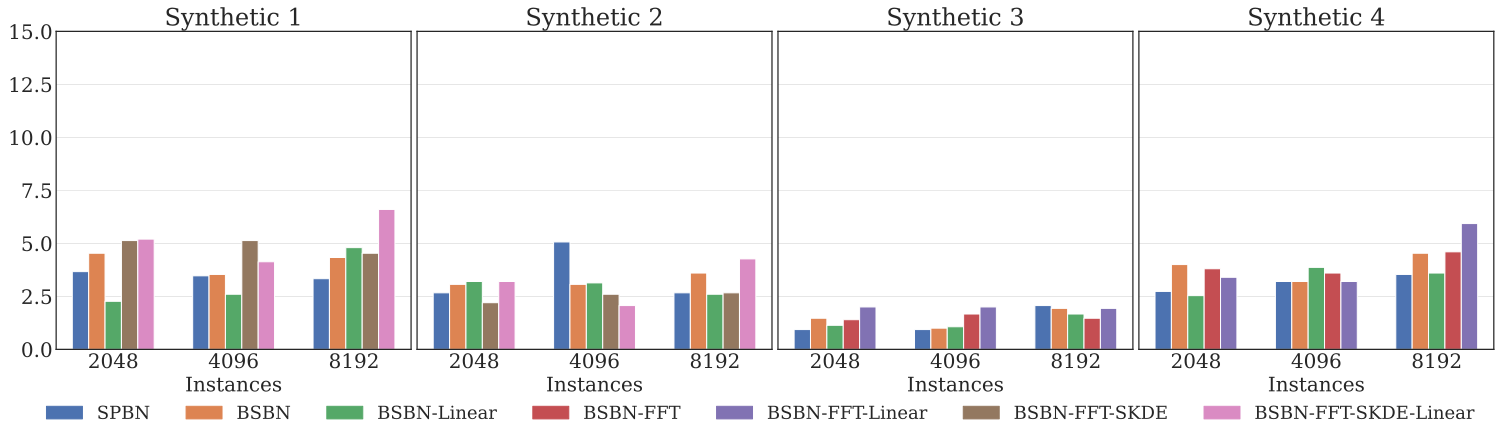

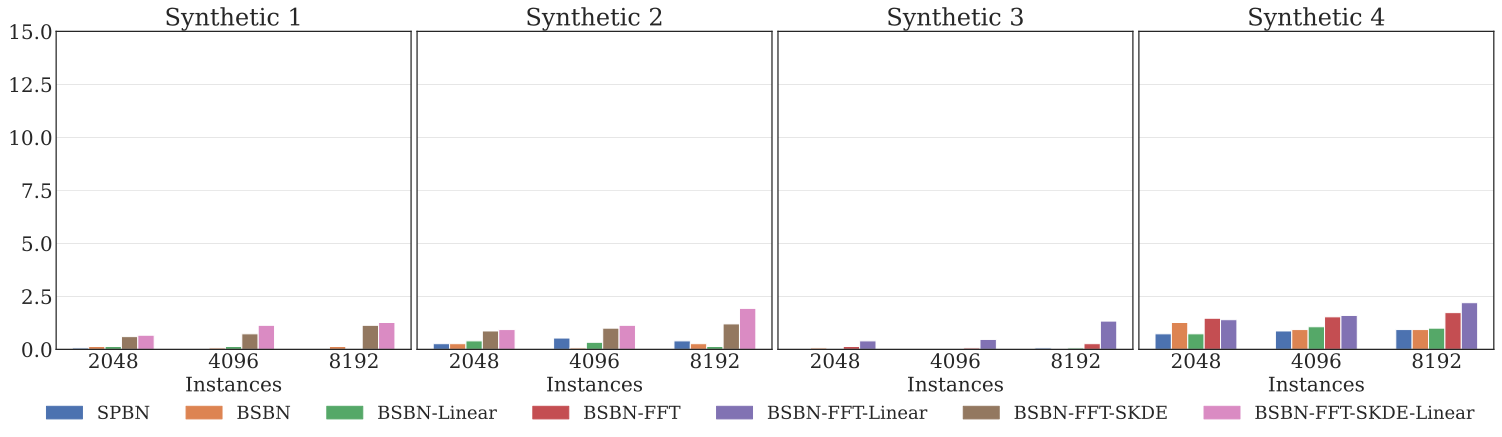

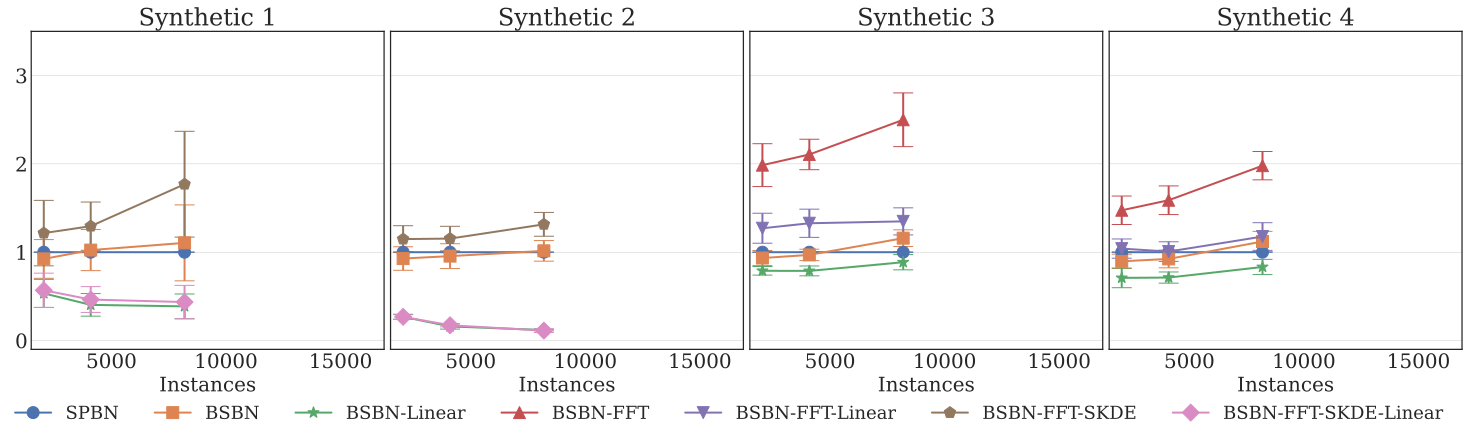

                         hamming  shamming  thamming        train         slogl     slogl_REF  Ratio Train   Logl diff    Ratio Test Instances Simulation
Model                                                                                                                                                    
1.SPBN                  1.933333  4.666667  0.200000    16.553493 -29532.505147 -29401.085507     1.000000  131.419640  6.782163e+09      2048          1
1.SPBN                  2.666667  3.400000  0.333333    48.686727 -57062.806793 -57099.932960     1.000000  -37.126167  4.317591e+09      2048          2
1.SPBN                  0.000000  0.933333  0.000000     9.648313 -35152.316800 -35143.818720     1.000000    8.498080  1.038387e+10      2048          3
1.SPBN                  1.200000  2.466667  0.600000    32.356547 -65649.424833 -65608.719107     1.000000   40.705727  8.159529e+09      2048          4
1.SPBN                  2.066667  2.866667  0.000000    30.411727 -29250.583

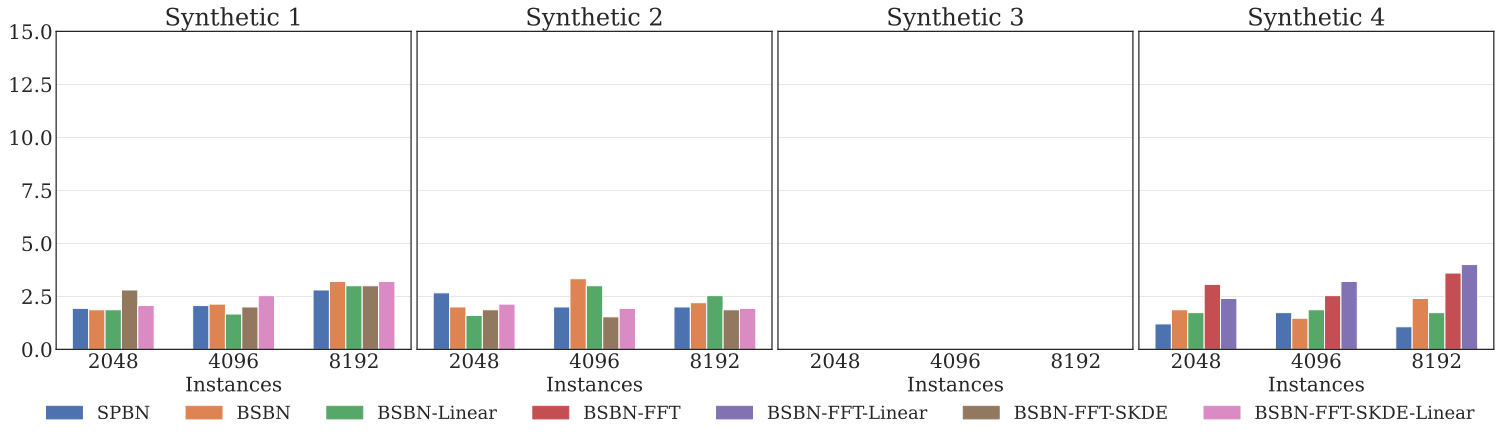

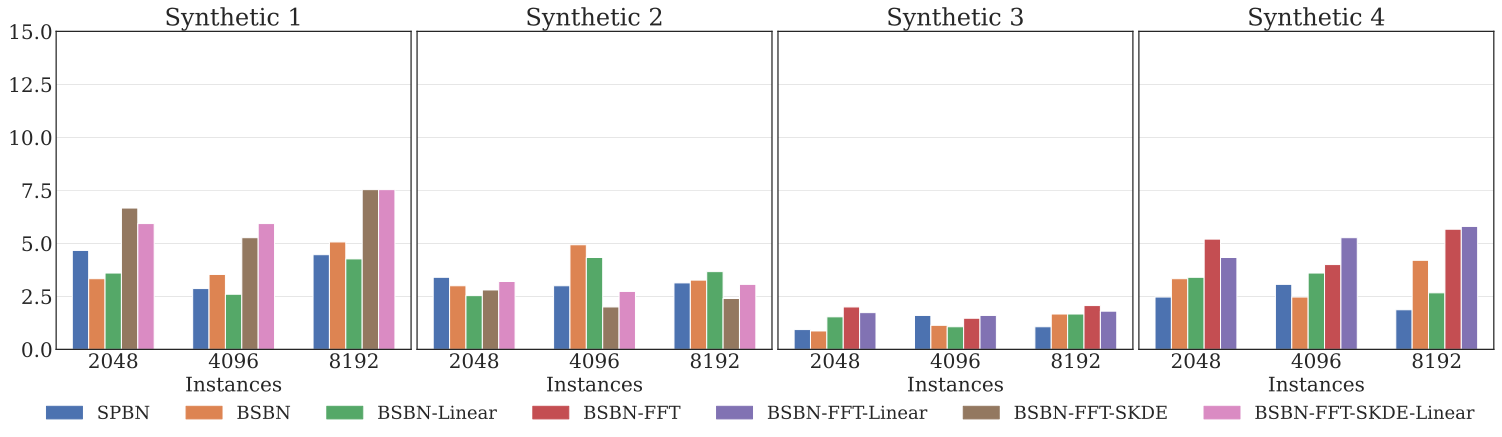

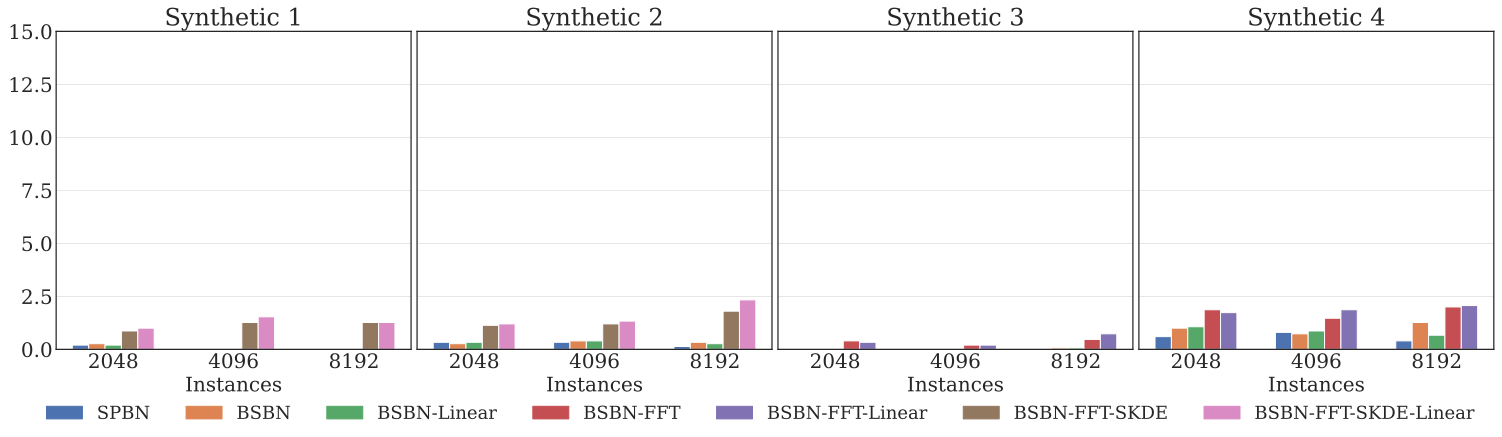

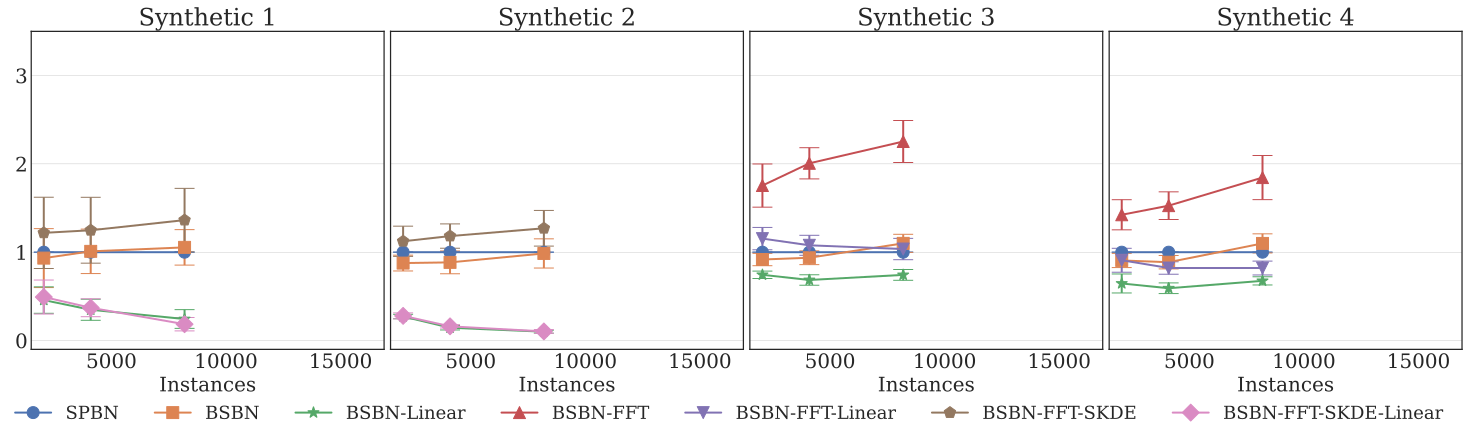

                         hamming  shamming  thamming       train         slogl     slogl_REF  Ratio Train   Logl diff    Ratio Test Instances Simulation
Model                                                                                                                                                   
1.SPBN                  1.933333  3.333333  0.200000   17.244927 -29516.106707 -29401.085507     1.000000  115.021200  6.498739e+09      2048          1
1.SPBN                  1.533333  2.333333  0.266667   48.633860 -57050.195193 -57099.932960     1.000000  -49.737767  4.328216e+09      2048          2
1.SPBN                  0.000000  1.133333  0.000000    9.743113 -35153.319653 -35143.818720     1.000000    9.500933  9.983544e+09      2048          3
1.SPBN                  1.533333  3.133333  1.000000   32.566840 -65669.204480 -65608.719107     1.000000   60.485373  8.061853e+09      2048          4
1.SPBN                  1.866667  2.933333  0.000000   30.517933 -29233.749900 -29

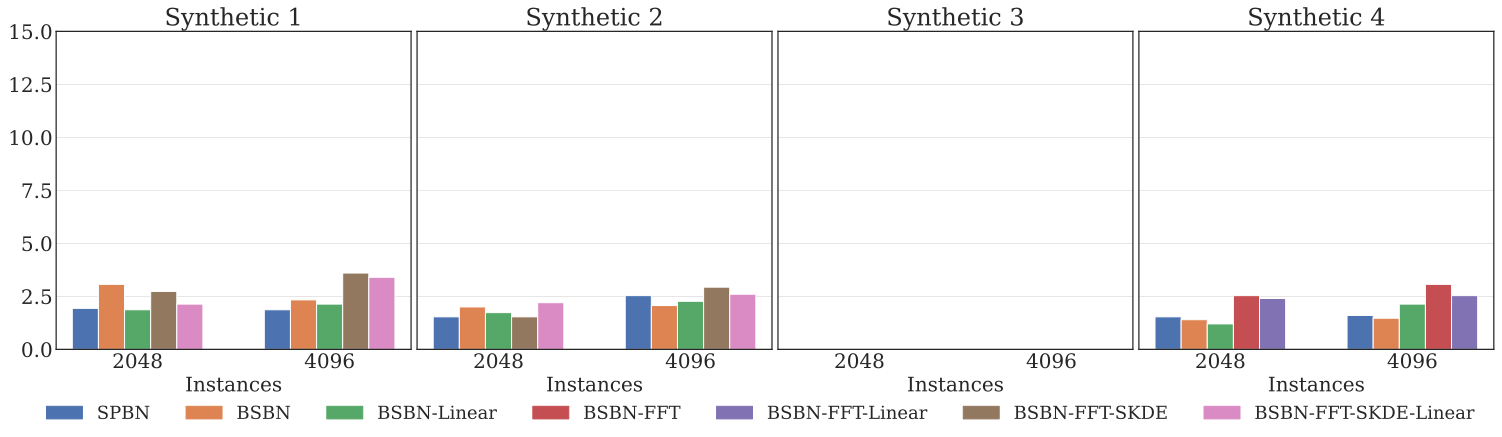

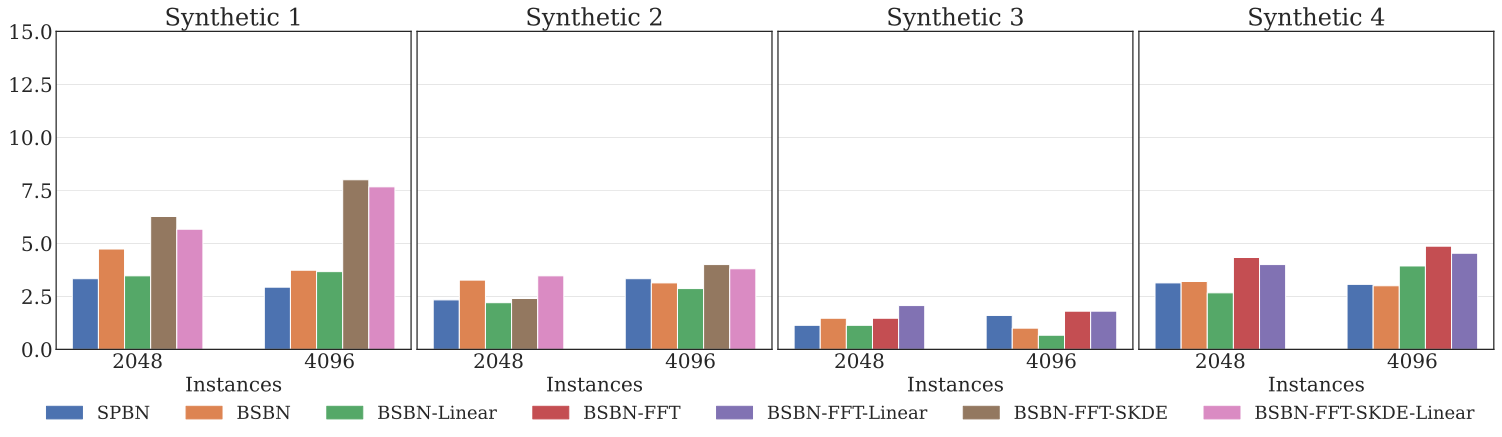

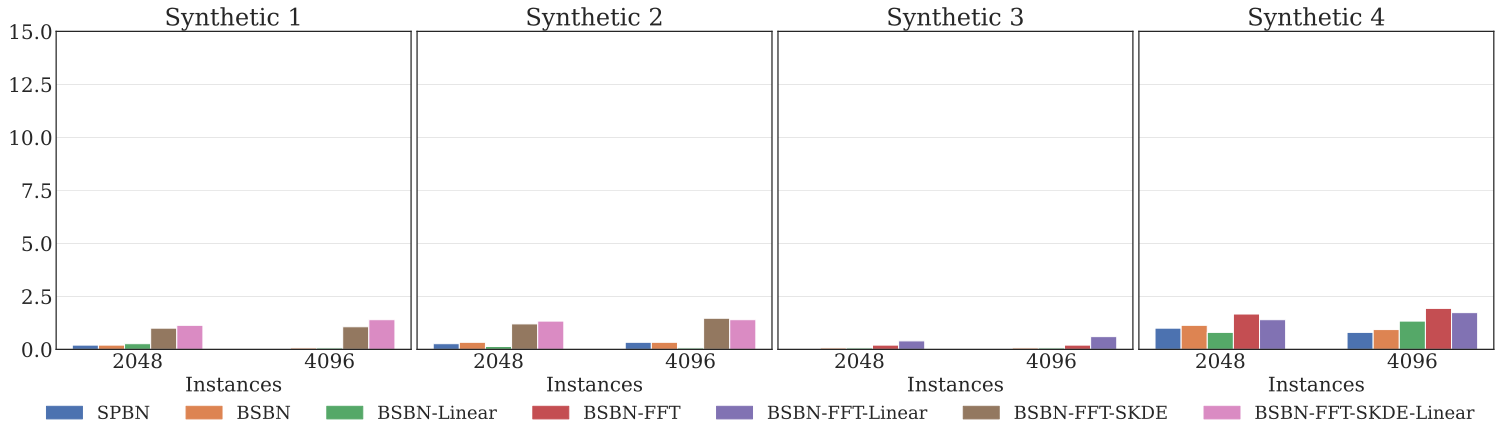

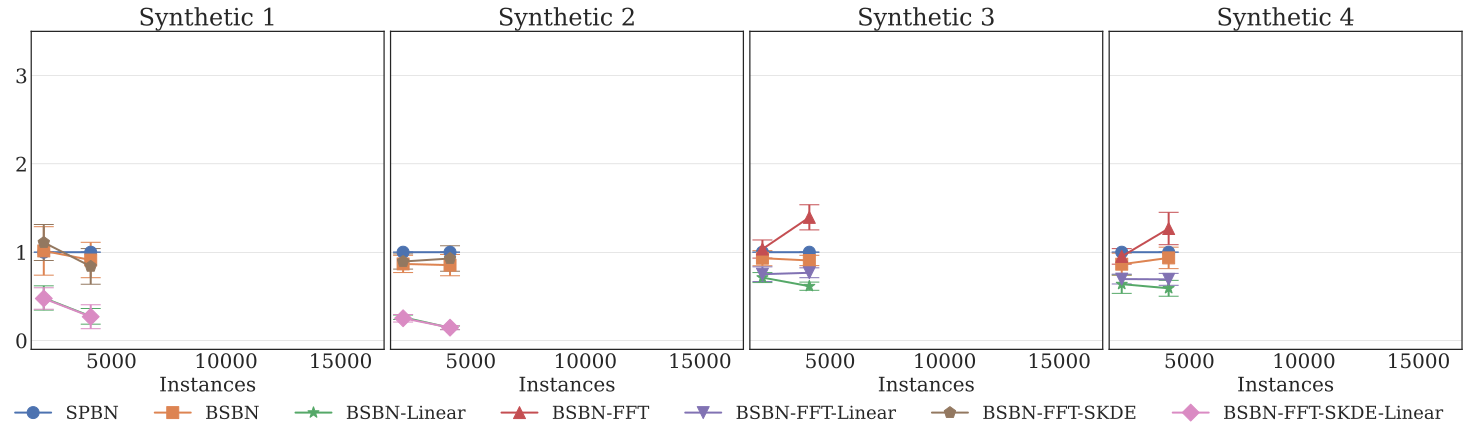

In [ ]:

exp = f'results/exp_simu/Mfix'
head = 15
thres = 0.5
sortby = {"by": 'shamming', "ascending": True}


paths = ns.natsorted(glob.glob(f'{exp}/simu*.json'))
print(paths)
# Load results from JSON files

for path in paths:
    M = int(path.split('.')[0].split('_')[-1])
    with open(path, 'r') as json_file:
        results = json.load(json_file)
    
        all_exps = []
        all_exps_std = []
        all_exps2 = []
        
        models = sorted(list(results.keys()))
        dataframes = []
        means = []
        model_index, instances_col,simucol = [],[],[]

        for nm, model in enumerate(models):
            instances = results[model].keys()

            for n in instances:
                simus = results[model][n].keys()

                for simu in simus:
                    ## PREPARE DATAFRAMES
                    reader = ExperimentsReader(results[model][n][simu], model, 'REF')
                    df_all = reader.return_dataframe(simulated=True).reset_index()
                    
                    
                    reader0 = ExperimentsReader(results[models[0]][n][simu], models[0], 'REF')
                    df0 = reader0.return_dataframe(simulated=True).reset_index()

                    df_all['Ratio Train'] = df0['train']/df_all['train']

                
                    df_sort = df_all.sort_values(**sortby).head(head).drop(columns=['model'],axis=1).round(4)
                    df_sort['Logl diff'] = df_sort['slogl_REF'] - df_sort['slogl']
                    df_sort['Ratio Test'] = df_sort['test_REF']/df_sort['test']
                    
                    df_sort_mean = df_sort.mean().to_frame().T
                    df_sort_std = df_sort.std().to_frame().T
                    dataframes.append((df_sort, df_sort_mean, df_sort_std))
                
                    # DRAW GRAPHS
                    kwargs = reader.return_average_dag(model, thres, df_sort['index'].tolist())
                    config = get_config(int(simu[-1]))
                    ref_model = pbn.SemiparametricBN(**config)
                    
                    if "BSBN" in model and len(kwargs['arcs']) == 0:
                        avg_model = None
                        df_mean = pd.DataFrame({'hamming': [-1], 'shamming': [-1], 'thamming': [-1]})
                        means.append(df_mean)
                    else:
                        avg_model = pbn.FourierNetwork(**kwargs) if 'SPBN' not in model else pbn.SemiparametricBN(**kwargs)
                        dagpath = f"{exp}/comparison_dag/{M}/{model}"
                        if not os.path.exists(dagpath):
                            os.makedirs(dagpath)
                        
                        hmd = hamming_distance(avg_model.arcs(), ref_model.arcs(), reader.nodemap)
                        shd = structural_hamming_distance(avg_model.arcs(), ref_model.arcs())
                        thmd = node_type_hamming_distance(avg_model.node_types(), ref_model.node_types())
                        
                        df_mean = pd.DataFrame({'hamming': [hmd], 'shamming': [shd], 'thamming': [thmd]})
                        means.append(df_mean)
                        compare_graphs(ref_model, avg_model, filename=dagpath+f"/{simu}_{n}.pdf", size=20)

                    model_index.append(model)
                    instances_col.append(n) 
                    simucol.append(simu[-1])

                




        all_df= pd.concat([df_mean for _, df_mean,_ in dataframes]).reset_index(drop=True).drop(columns=['index','rmse','rmae','test','test_REF'], axis=1)
        all_df.index = model_index
        all_df.index.name = 'Model'
        all_df['Instances'] = instances_col
        all_df['Simulation'] = simucol

        means_df = pd.concat(means).reset_index(drop=True)
        means_df.index = model_index
        means_df.index.name = 'Model'                               
        means_df['Instances'] = instances_col
        means_df['Simulation'] = simucol

        all_df_std= pd.concat([df_std for _, _,df_std in dataframes]).reset_index(drop=True).drop(columns=['index','rmse','rmae','test','test_REF'], axis=1)
        all_df_std.index = model_index
        all_df_std.index.name = 'Model'
        all_df_std['Instances'] = instances_col
        all_df_std['Simulation'] = simucol

        print(all_df.to_string())
        
        

        for col in ['hamming', 'shamming', 'thamming', 'Ratio Train']:
            markers = ['o', 's', '*', '^', 'v', 'p', 'D']  # Define a list of markers
            cmap = sns.color_palette("deep")
            sns.set_palette("deep")  
            fig, axes = plt.subplots(1, 4, figsize=(21, 6))
            for ax, simu in zip(axes.flatten(), range(1,5)):
                all_df_simu = all_df[all_df['Simulation'] == str(simu)]
                all_df_simu_std = all_df_std[all_df_std['Simulation'] == str(simu)]
                all_df_simu_means = means_df[means_df['Simulation'] == str(simu)]
   

                bar_width = 0.2  # Width of the bars
                spacing = 0.01  # Space between groups of bars
                indexmodel = 0
                for model, color, mark in zip(models, cmap, markers):
                    g0 = all_df_simu.reset_index()
                    g0_means = all_df_simu_means.reset_index()
                    g0_std = all_df_simu_std.reset_index()

                    g1 = g0[g0['Model'] == model]
                    g2 = g0_means[g0_means['Model'] == model]
                    g3 = g0_std[g0_std['Model'] == model]

                    if g1['hamming'].values[0] == -1:
                        continue
                    else:
                        if col == 'Ratio Train':
                            ax.errorbar(x=g1['Instances'].astype(int), y=g1[col], yerr=g3[col], color=color, marker=mark, capsize = 10, markersize=12, linewidth=2)
                            ax.set_title(f'Synthetic {simu}')
                            ax.set_xlabel('Instances')
                            
                            ax.set_ylim(-0.1,3.5)
                            ax.set_xlim(1500,16900)
                            if ax != axes[0]:
                                ax.set_yticklabels([]) # Hide y-axis for other subplots
                            ax.tick_params(axis='both', which='major')
                            ax.grid(axis='y', linestyle='-', color='gray', alpha=0.5)  # Customize as needed
                            

                        else:
                            x = np.arange(len(g1['Instances'])) * (len(models) * (bar_width + spacing))  # Adjust x positions
                            indexmodel += 1
                            simu = g1['Simulation'].values[0]
                            # plt.suptitle(col)

                            ax.bar(x + bar_width * indexmodel, g1[col].values, bar_width, color=color, edgecolor='white')
                            ax.set_title(f'Synthetic {simu}')
                            ax.set_xlabel('Instances')
                            if ax != axes[0]:
                                ax.set_yticklabels([]) # Hide y-axis for other subplots
                                
                            ax.set_xticks(x + bar_width * (len(models) - 1) / 2)
                            ax.set_xticklabels(g1['Instances'])
                            if col=='thamming':
                                ax.set_ylim(0,15)
                            else:
                                ax.set_ylim(0,15)
                            ax.tick_params(axis='y', which='major')
                            ax.grid(axis='y', linestyle='-', color='gray', alpha=0.5)  # Customize as needed

            
            from matplotlib.patches import Patch
            from matplotlib.lines import Line2D
            if col == 'Ratio Train':
                handles = [
                Line2D([0], [0], 
                    color=cmap[i], 
                    marker=markers[i], 
                    linestyle='-', 
                    markersize=12, 
                    linewidth=2, 
                    label=models[i][2:]) for i in range(len(models))
                ]
            else:
                handles = [Patch(color=cmap[i], label=models[i][2:]) for i in range(len(models))]
            fig.legend(handles=handles, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
            fig.tight_layout(w_pad=0.3)
            plt.show()

            os.makedirs(f"{exp}/plots/{M}", exist_ok=True)
            fig.savefig(f'{exp}/plots/{M}/{col}.pdf', format='pdf', bbox_inches='tight')




        
        all_exps.append(all_df)
        all_exps2.append(means_df)
        all_exps_std.append(all_df_std)

             
                    

### Parameters

['results/exp_simu/Mfix_sameDAG/simu_all_30.json', 'results/exp_simu/Mfix_sameDAG/simu_all_50.json', 'results/exp_simu/Mfix_sameDAG/simu_all_80.json', 'results/exp_simu/Mfix_sameDAG/simu_all_100.json']
                           rmse     rmae      test  test_REF        slogl    slogl_REF   Logl diff  Ratio Test Instances Simulation
Model                                                                                                                              
2.BSBN                  0.28022  1.21856   0.11690   0.29239 -29668.54207 -29386.28064   282.26143    2.528044      2048          1
2.BSBN                  0.16094  0.38598   0.42814   0.52004 -57189.17869 -57088.14627   101.03242    1.218321      2048          2
2.BSBN                  0.04669  0.22415   0.02078   0.18276 -35224.92583 -35160.47200    64.45383    8.944273      2048          3
2.BSBN                  0.10128  0.24947   0.02847   0.22169 -65712.85354 -65592.58223   120.27131    7.822470      2048          4
2.BSBN

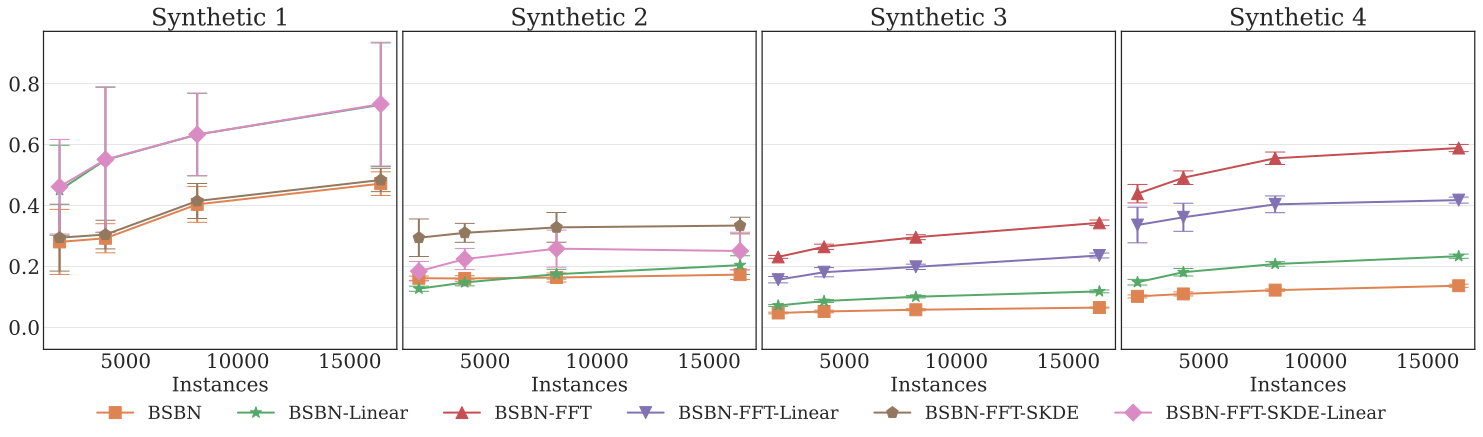

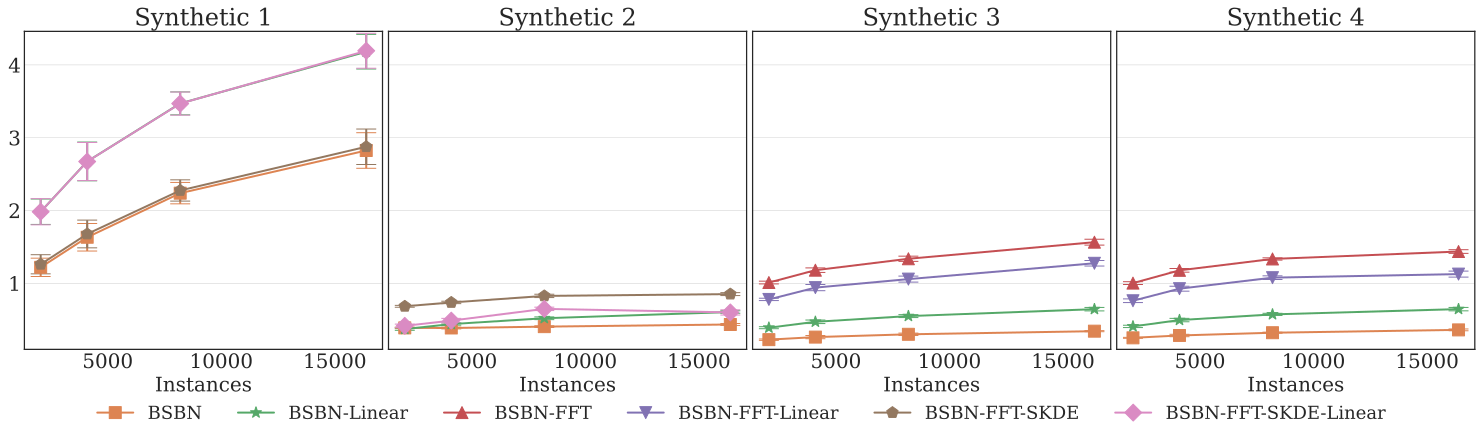

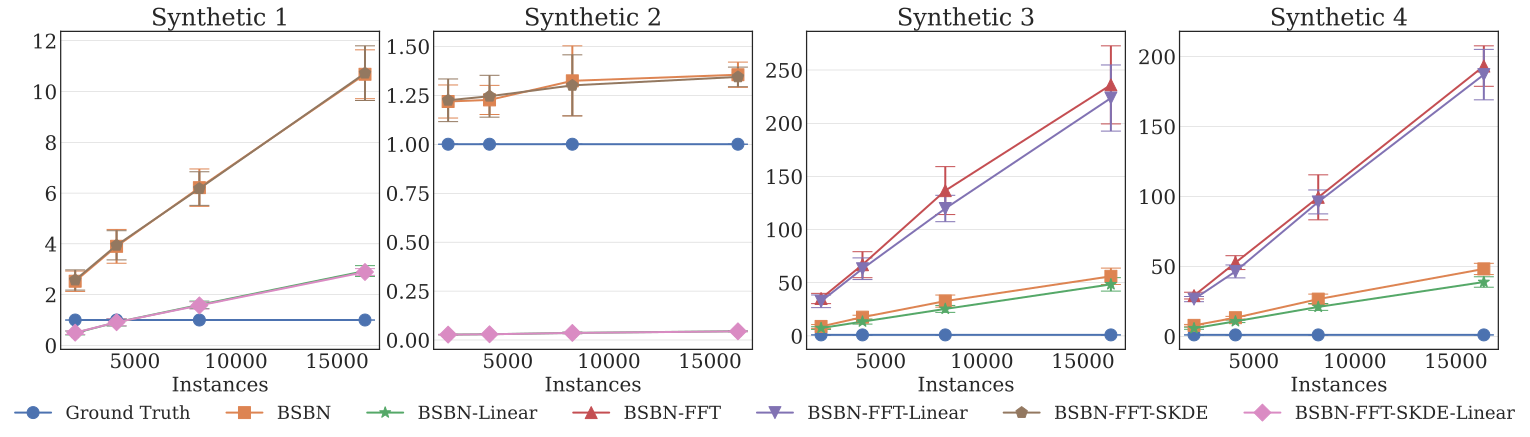

                           rmse     rmae       test  test_REF        slogl    slogl_REF  Logl diff  Ratio Test Instances Simulation
Model                                                                                                                              
2.BSBN                  0.13990  0.51987    0.18938   0.28686 -29519.76854 -29408.76371  111.00483    1.516661      2048          1
2.BSBN                  0.09483  0.21525    0.46323   0.49363 -57107.05734 -57071.92975   35.12759    1.070453      2048          2
2.BSBN                  0.02165  0.09393    0.03442   0.17543 -35175.93104 -35155.64733   20.28371    5.154074      2048          3
2.BSBN                  0.04877  0.11243    0.04932   0.21674 -65623.82134 -65581.16962   42.65172    4.461243      2048          4
2.BSBN                  0.14009  0.67756    0.29730   0.55000 -29200.78645 -29042.07220  158.71425    1.860567      4096          1
2.BSBN                  0.09371  0.20940    0.88675   1.00727 -56779.85156 -

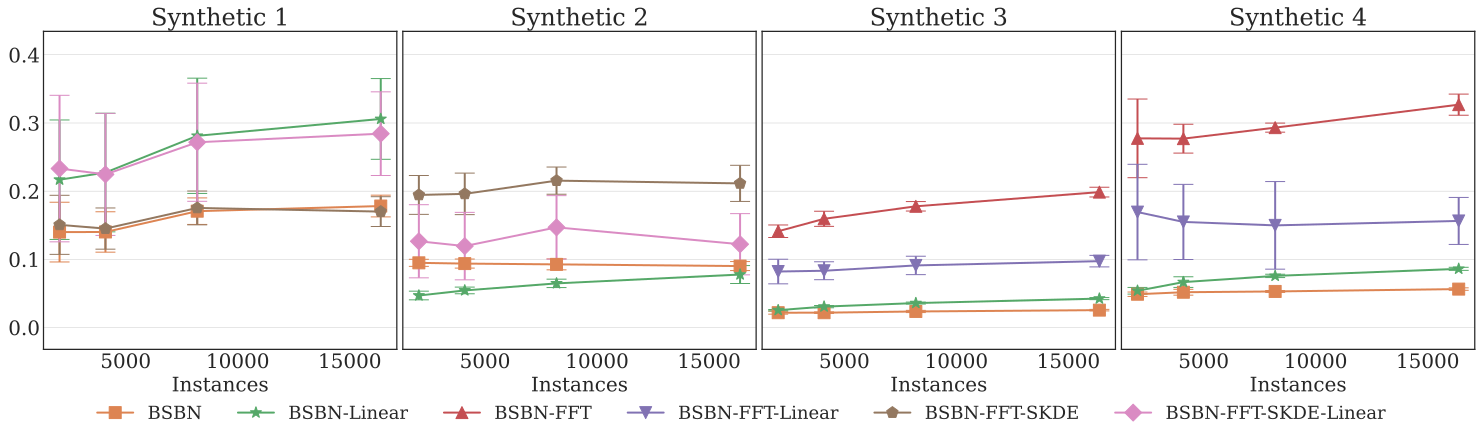

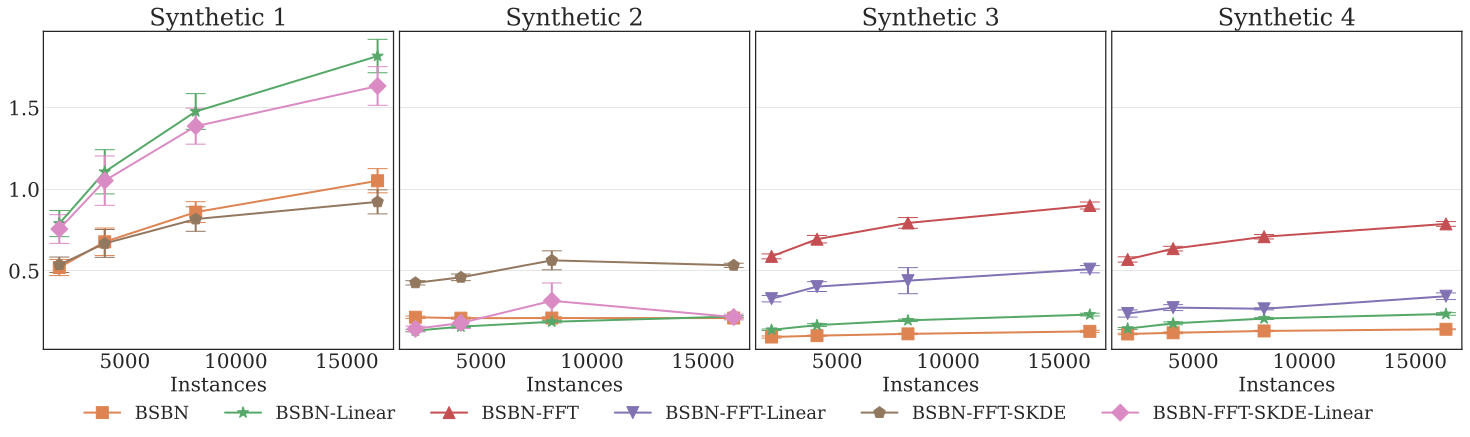

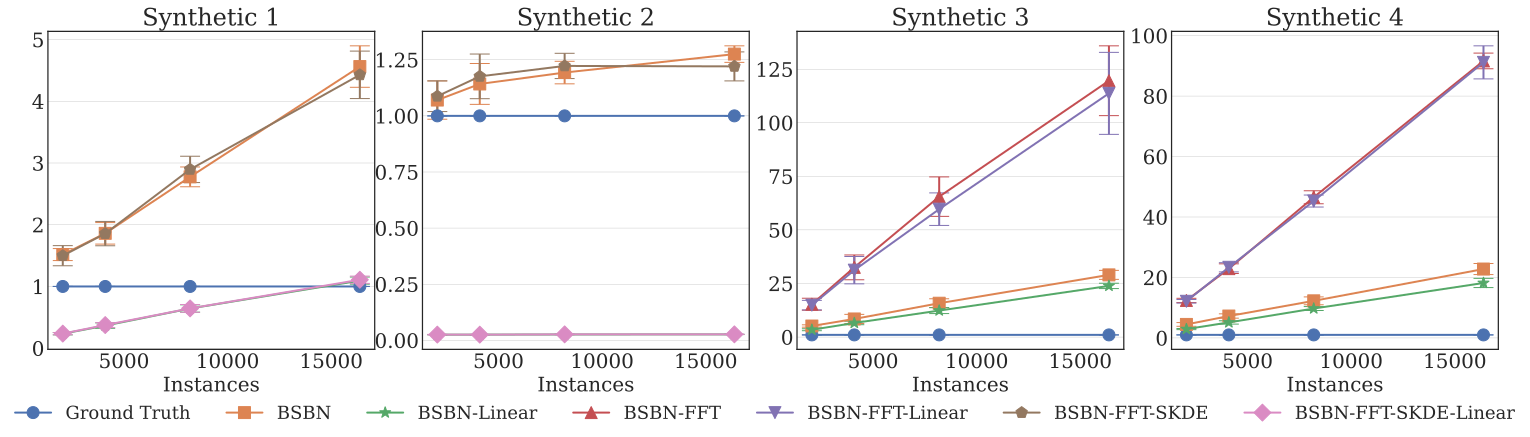

                           rmse     rmae       test  test_REF        slogl    slogl_REF  Logl diff  Ratio Test Instances Simulation
Model                                                                                                                              
2.BSBN                  0.09143  0.26002    0.23717   0.27705 -29455.39258 -29408.76371   46.62887    1.169564      2048          1
2.BSBN                  0.05685  0.12839    0.46485   0.48858 -57095.76727 -57081.77728   13.98999    1.052242      2048          2
2.BSBN                  0.01211  0.05149    0.05353   0.17436 -35159.61804 -35151.24648    8.37156    3.290254      2048          3
2.BSBN                  0.02976  0.06110    0.07782   0.21478 -65622.71034 -65606.74595   15.96439    2.782253      2048          4
2.BSBN                  0.09266  0.31058    0.42741   0.58645 -29114.09375 -29054.73761   59.35614    1.374956      4096          1
2.BSBN                  0.05710  0.12568    0.91995   0.98482 -56711.47882 -

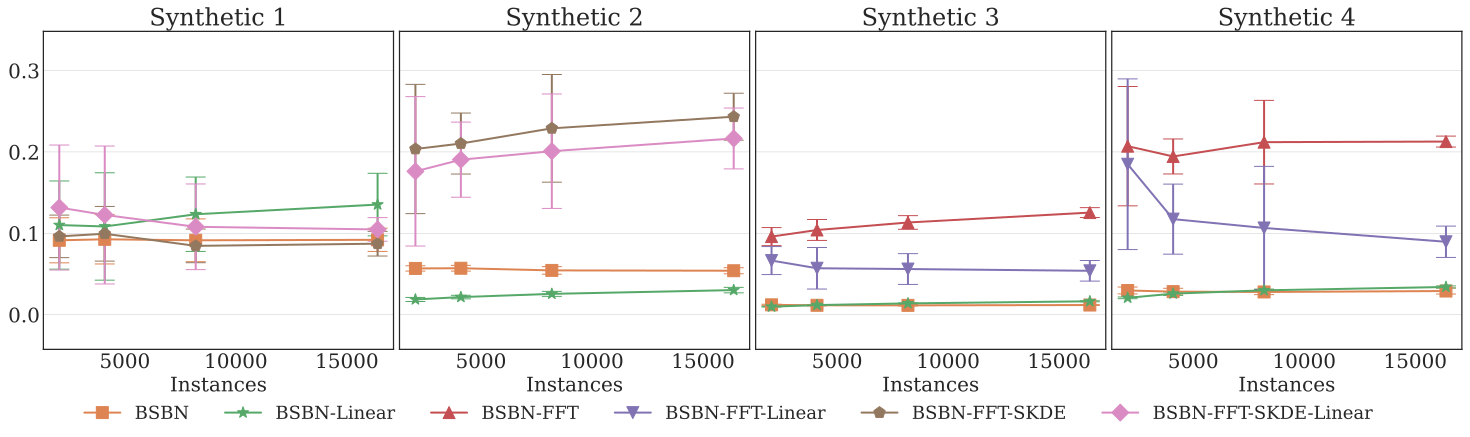

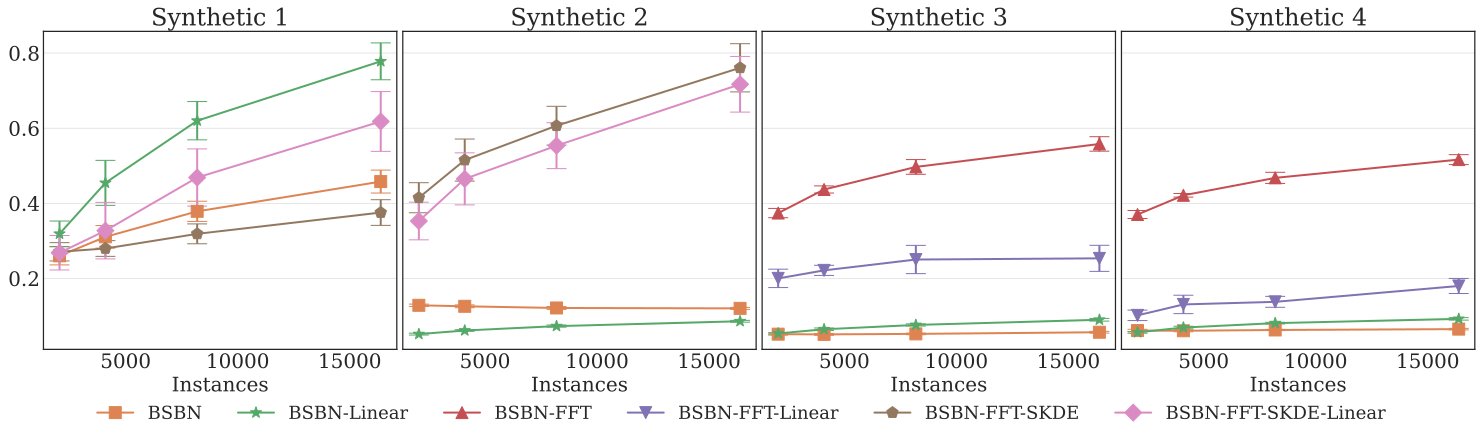

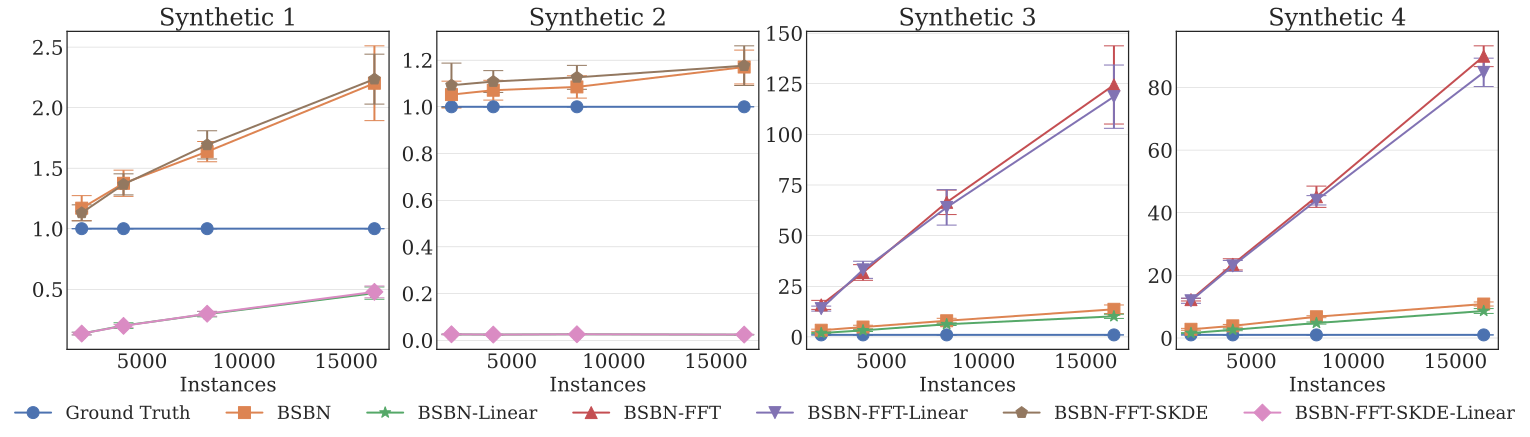

                           rmse     rmae       test  test_REF        slogl    slogl_REF  Logl diff  Ratio Test Instances Simulation
Model                                                                                                                              
2.BSBN                  0.08008  0.19051    0.24752   0.29128 -29438.46618 -29408.76371   29.70247    1.176474      2048          1
2.BSBN                  0.00922  0.03782    0.06744   0.19062 -35147.22073 -35142.59070    4.63003    2.874648      2048          3
2.BSBN                  0.04623  0.10331    0.48156   0.48715 -57085.28660 -57076.03043    9.25617    1.014556      2048          2
2.BSBN                  0.02190  0.04715    0.09262   0.21423 -65589.96409 -65579.50244   10.46165    2.321904      2048          4
2.BSBN                  0.07424  0.21862    0.46779   0.54914 -29093.14279 -29054.04966   39.09313    1.175527      4096          1
2.BSBN                  0.00854  0.03658    0.09549   0.34579 -34804.93436 -

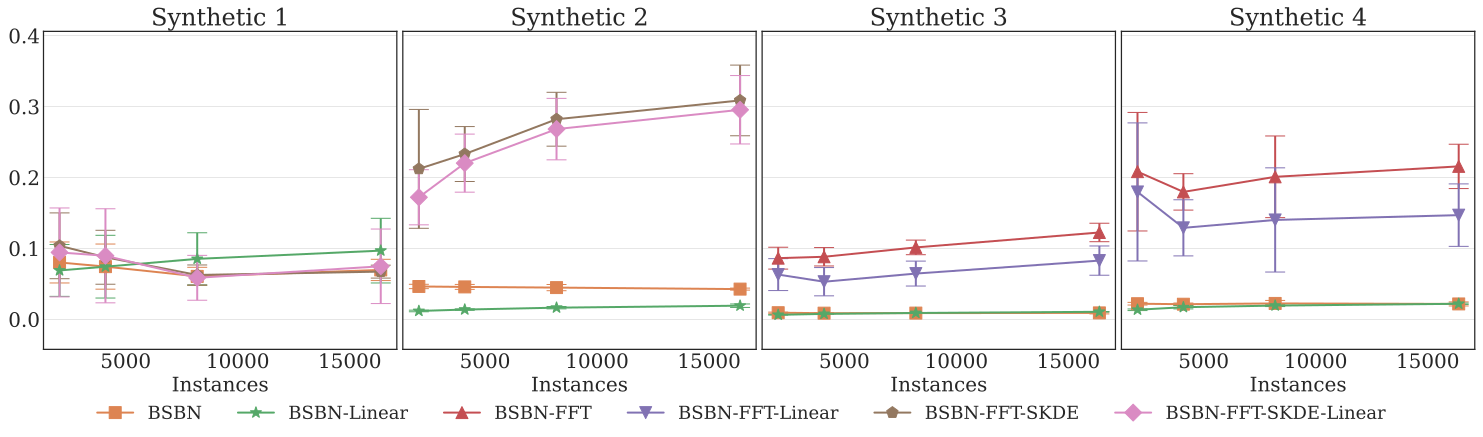

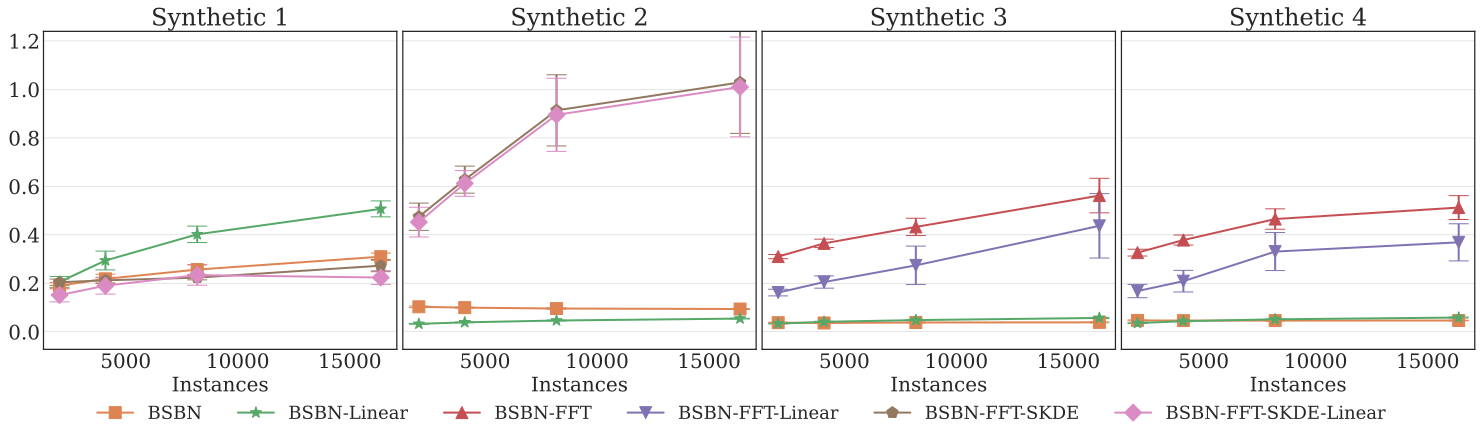

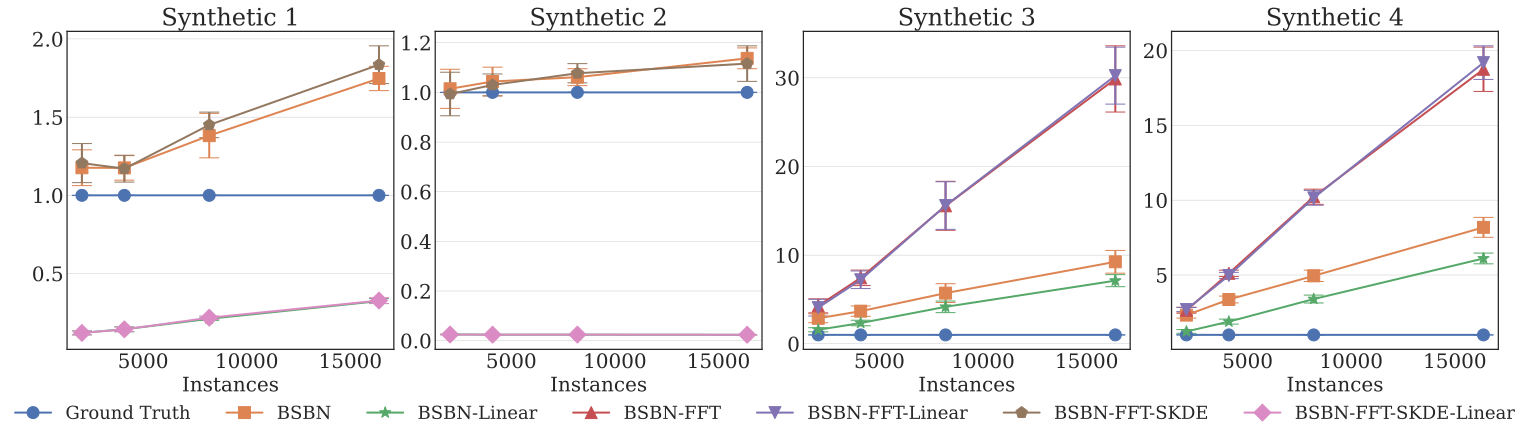

In [ ]:

# Define experiment parameters
exp = f'results/exp_simu/Mfix_sameDAG'
head = 10
thres = 0.6
sortby = {"by": 'rmae', "ascending": True}



paths = ns.natsorted(glob.glob(f'{exp}/simu*.json'))
print(paths)


for path in paths:
    M = int(path.split('.')[0].split('_')[-1])
    with open(path, 'r') as json_file:
        results = json.load(json_file)
    
        all_exps = []
        all_exps_std = []

        models = sorted(list(results.keys()))
        dataframes = []
        model_index, instances_col,simucol = [],[],[]

        for nm, model in enumerate(models):
            instances = results[model].keys()

            for n in instances:
                simus = results[model][n].keys()

                for simu in simus:
                    ## PREPARE DATAFRAMES
                    reader = ExperimentsReader(results[model][n][simu], model, 'REF')
                    df_all = reader.return_dataframe(simulated=True).reset_index()

                
                    df_sort = df_all.sort_values(**sortby).head(head).drop(columns=['model'],axis=1).round(4)
                    df_sort['Logl diff'] = df_sort['slogl_REF'] - df_sort['slogl']
                    df_sort['Ratio Test'] = df_sort['test_REF']/df_sort['test']
                    
                    df_sort_mean = df_sort.mean().to_frame().T
                    df_sort_std = df_sort.std().to_frame().T
                    dataframes.append((df_sort, df_sort_mean, df_sort_std))

                    model_index.append(model)
                    instances_col.append(n) 
                    simucol.append(simu[-1])


                




        all_df= pd.concat([df_mean for _, df_mean,_ in dataframes]).reset_index(drop=True).drop(columns=['index','hamming','shamming','thamming','train'], axis=1)
        all_df.index = model_index
        all_df.index.name = 'Model'
        all_df['Instances'] = instances_col
        all_df['Simulation'] = simucol

        all_df_std= pd.concat([df_std for _, _,df_std in dataframes]).reset_index(drop=True).drop(columns=['index','hamming','shamming','thamming','train'], axis=1)
        all_df_std.index = model_index
        all_df_std.index.name = 'Model'
        all_df_std['Instances'] = instances_col
        all_df_std['Simulation'] = simucol

        print(all_df.to_string())


        # plt.style.use('default')
        for col in ['rmse', 'rmae', 'Ratio Test']:
            markers = ['o', 's', '*', '^', 'v', 'p', 'D']  # Define a list of markers
            cmap = sns.color_palette("deep")
            sns.set_palette("deep")  
            fig, axes = plt.subplots(1, 4, figsize=(21, 6))
            fig.subplots_adjust(wspace=0)
            for ax, simu in zip(axes.flatten(), range(1,5)):
                all_df_simu = all_df[all_df['Simulation'] == str(simu)]
                all_df_simu_std = all_df_std[all_df_std['Simulation'] == str(simu)]
                
                if col !='Ratio Test':
                    dfmodel = all_df[col].values
                    dfmodel_std = all_df_std[col].values
                    
                    maxval = dfmodel.max() + dfmodel_std.max()
                    minval = dfmodel[dfmodel>0].min() - dfmodel_std.max()/2
                else:
                    ax.errorbar(x=g1['Instances'].astype(int), y=[1]*4, yerr=[0]*4, color=cmap[0], label="Ground Truth", marker=markers[0], capsize = 10, markersize=12, linewidth=2)
                for model, color, mark in zip(models, cmap[1:], markers[1:]):
                    g0 = all_df_simu.reset_index()
                    g0_std = all_df_simu_std.reset_index()

                    g1 = g0[g0['Model'] == model]
                    g3 = g0_std[g0_std['Model'] == model]

                    if g1['rmse'].values[0] == -1:
                        continue
                    else:
                        ax.errorbar(x=g1['Instances'].astype(int), y=g1[col], yerr=g3[col], color=color, label=model, marker=mark, capsize = 10, markersize=12, linewidth=2)
                        ax.set_title(f'Synthetic {simu}')
                        ax.set_xlabel('Instances')
                        if col !='Ratio Test':
                            ax.set_ylim(minval,maxval)
                                                
                        if ax != axes[0] and col != 'Ratio Test':
                            ax.set_yticklabels([])

                        

                        ax.tick_params(axis='both', which='major')
                        ax.grid(axis='y', linestyle='-', color='gray', alpha=0.5)  # Customize as needed
                            
            
            from matplotlib.patches import Patch
            from matplotlib.lines import Line2D
            handle0 = [Line2D([0], [0], 
                color=cmap[0], 
                marker=markers[0], 
                linestyle='-', 
                markersize=12, 
                linewidth=2, 
                label="Ground Truth")]
            handles = [
            Line2D([0], [0], 
                color=cmap[1:][i], 
                marker=markers[1:][i], 
                linestyle='-', 
                markersize=12, 
                linewidth=2, 
                label=models[i][2:]) for i in range(len(models))
            ]
            handle = handle0 + handles if col == 'Ratio Test' else handles
            fig.legend(handles=handle, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
            fig.tight_layout(w_pad=0.3)
            plt.show()

            os.makedirs(f'{exp}/plots/{M}', exist_ok=True)
            fig.savefig(f'{exp}/plots/{M}/{col}.pdf', format='pdf', bbox_inches='tight')





        all_exps.append(all_df)
        all_exps_std.append(all_df_std)
